In [1]:
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress/')

from ADlasso2 import AD2_w_utils as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [2]:
import scanpy as sc
import scvelo as scv

data = scv.datasets.pancreas(file_path='/Users/evanli/Documents/Research_datasets/endocrinogenesis_day15.h5ad')
label = data.obs['clusters'].tolist()

In [11]:
q = np.unique(label)
q

array(['Alpha', 'Beta', 'Delta', 'Ductal', 'Epsilon', 'Ngn3 high EP',
       'Ngn3 low EP', 'Pre-endocrine'], dtype='<U13')

## Read result_dict from json

Processing:  Alpha
Optimal lambda: 0.031622776601683826
Processing:  Beta
Optimal lambda: 0.014677992676220709
Processing:  Delta
Optimal lambda: 0.146779926762207
Processing:  Ductal
Optimal lambda: 0.010000000000000005
Processing:  Epsilon
Optimal lambda: 0.046415888336127815
Processing:  Ngn3 high EP
Optimal lambda: 0.014677992676220709
Processing:  Ngn3 low EP
Optimal lambda: 0.21544346900318853
Processing:  Pre-endocrine
Optimal lambda: 0.006812920690579619


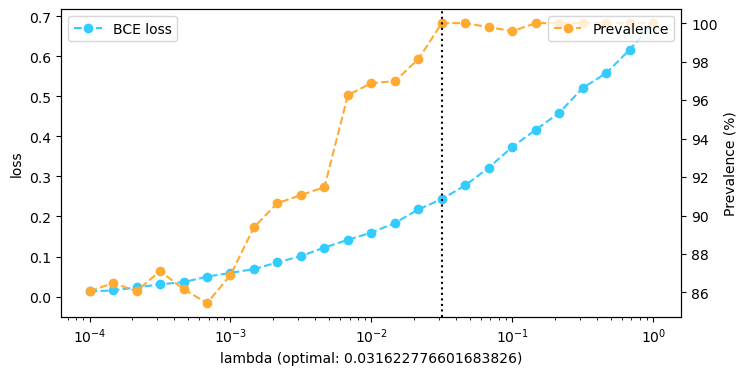

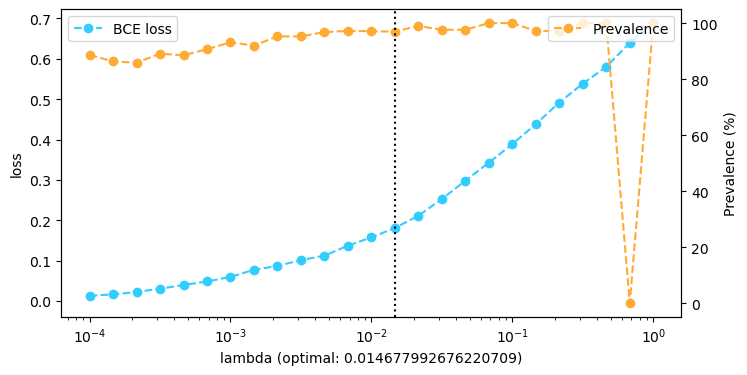

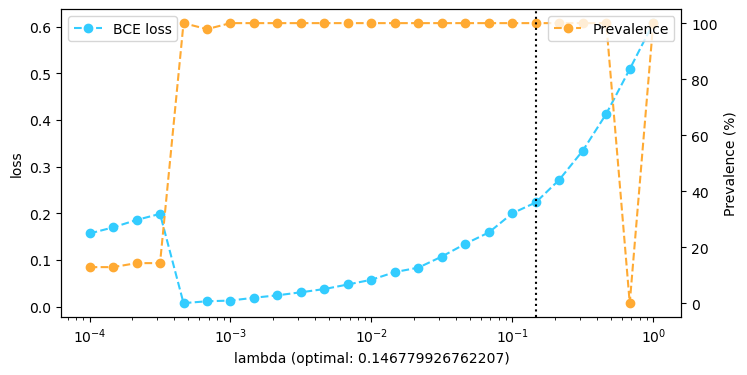

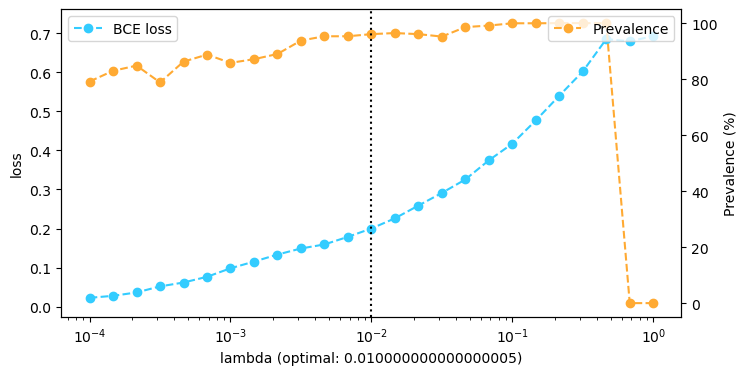

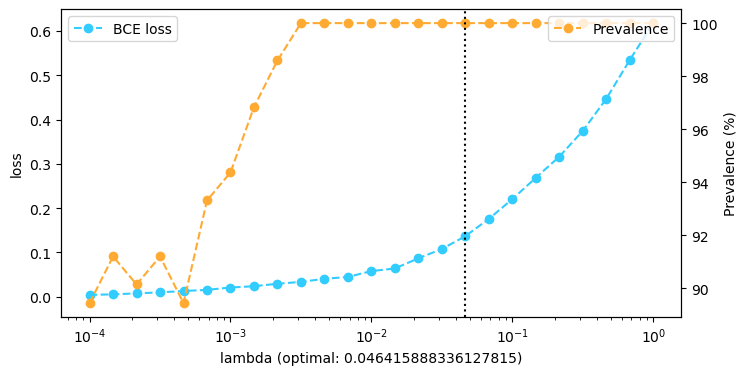

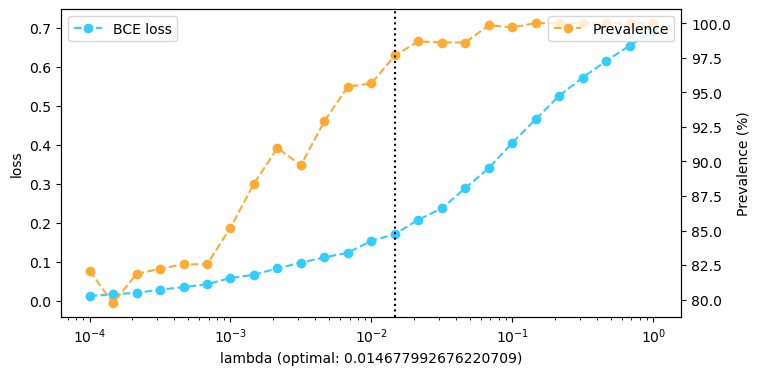

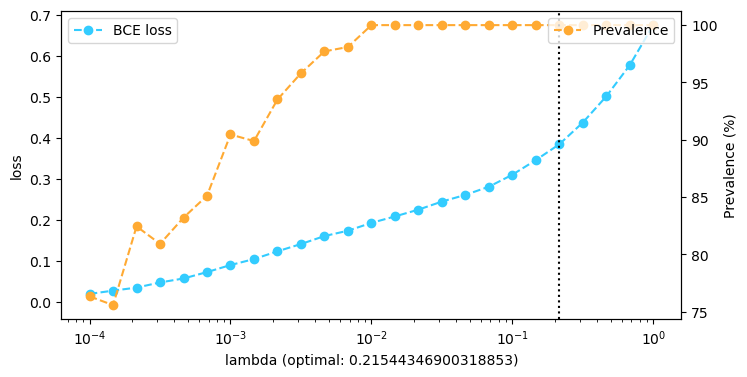

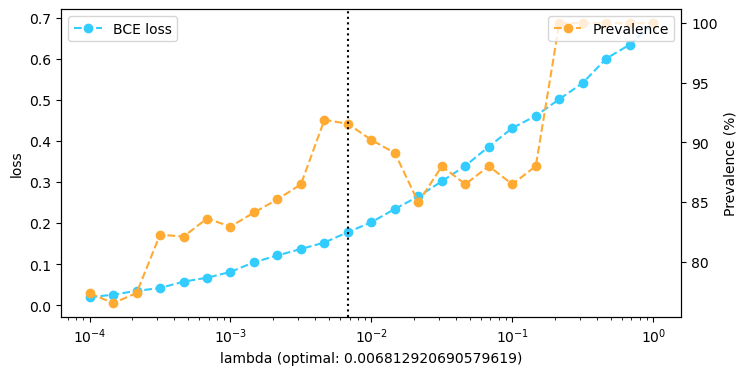

In [4]:
import json

loss_dict = {}
opt_lambda_dict = {}
prevalence_dict = {}
for celltype in np.unique(label).tolist():
    print('Processing: ', celltype)
    with open(f'./Pancreas_ADlasso/Pancreas_result/{celltype}/{celltype}_tuning.json') as f:
        result_dict = json.load(f)
    result_dict = {key: np.array(value) for key, value in result_dict.items()}

    opt_lmbd, fig = ad.lambda_decision(result_dict, k=2)
    opt_lambda_dict[celltype] = opt_lmbd
    print('Optimal lambda: {}'.format(opt_lmbd))

    loss_dict[celltype] = result_dict['loss_history']
    prevalence_dict[celltype] = result_dict['Prevalence']

In [5]:
opt_lambda_dict

{'Alpha': 0.031622776601683826,
 'Beta': 0.014677992676220709,
 'Delta': 0.146779926762207,
 'Ductal': 0.010000000000000005,
 'Epsilon': 0.046415888336127815,
 'Ngn3 high EP': 0.014677992676220709,
 'Ngn3 low EP': 0.21544346900318853,
 'Pre-endocrine': 0.006812920690579619}

In [6]:
with open('./Pancreas_ADlasso/Pancreas_result/opt_lambda.json', 'w') as f:
    json.dump(opt_lambda_dict, f)

## Plot summary loss vs. prevalance

In [6]:
log_lmbd_range = np.linspace(np.log(1e-4), np.log(1), 25)
lmbd_range = np.exp(log_lmbd_range)
print(lmbd_range)

[1.00000000e-04 1.46779927e-04 2.15443469e-04 3.16227766e-04
 4.64158883e-04 6.81292069e-04 1.00000000e-03 1.46779927e-03
 2.15443469e-03 3.16227766e-03 4.64158883e-03 6.81292069e-03
 1.00000000e-02 1.46779927e-02 2.15443469e-02 3.16227766e-02
 4.64158883e-02 6.81292069e-02 1.00000000e-01 1.46779927e-01
 2.15443469e-01 3.16227766e-01 4.64158883e-01 6.81292069e-01
 1.00000000e+00]


In [7]:
# create color palette for 8 cell types
import seaborn as sns

keys = list(loss_dict.keys())
palette = sns.color_palette('husl', n_colors=len(keys))
color_dict = dict(zip(keys, palette))

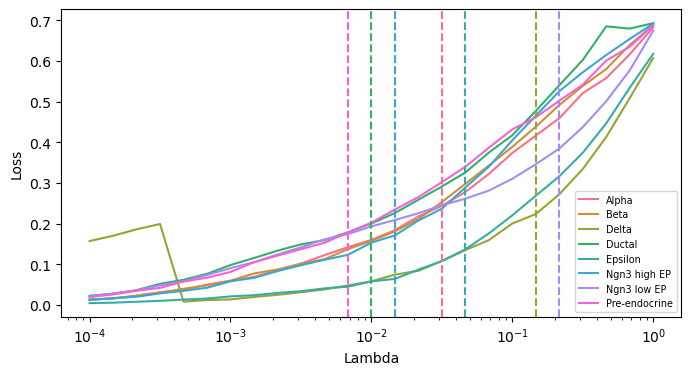

In [8]:
# Plot the loss history against lambda
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

# plot the y-axis values for each key in loss_dict
for key in loss_dict:
    ax.plot(lmbd_range, loss_dict[key], label=key, color=color_dict[key])

# add vertical dotted lines at the values in opt_lambda_dict
for key in opt_lambda_dict:
    ax.axvline(x=opt_lambda_dict[key], linestyle='--', color=color_dict[key])

# set the x-axis label
ax.set_xlabel('Lambda')
ax.set_xscale('log')

# set the y-axis label
ax.set_ylabel('Loss')

# add a legend
ax.legend(loc='lower right', fontsize='x-small')

# show the plot
plt.show()

## Find marker genes with optimal lambda